In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm
import re
from sklearn import preprocessing
import librosa
from imblearn.combine import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm, linear_model
import pywt
from util import convertEMF

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

In [72]:
from util import load

df, attachList = load.load(list(range(1, 7 + 1)) + [9])

df

../3rd天府杯A提/附件9\20.txt: 100%|██████████| 160/160 [00:03<00:00, 48.44it/s]


,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,...,9-11,9-12,9-13,9-14,9-15,9-16,9-17,9-18,9-19,9-20
0,0.031847,0.016663,0.020103,0.005837,-0.011276,-0.025771,0.021692,0.009281,0.010529,0.001247,...,0.093444,-0.039594,0.034525,-0.017206,0.037083,0.014242,-0.005727,0.001487,-0.004651,0.000754
1,-0.011189,-0.002048,0.006537,0.023145,0.012113,-0.017351,0.010933,-0.003817,0.004915,-0.007641,...,-0.098345,-0.065790,0.022830,-0.015803,0.024453,0.000677,-0.000582,0.009907,-0.003247,-0.007198
2,-0.019609,-0.007661,-0.002818,0.003030,0.021468,-0.009866,0.007658,-0.004752,0.003980,-0.002028,...,-0.083844,-0.049886,0.032186,-0.002705,0.038019,-0.008679,0.014387,-0.004594,-0.002780,-0.005327
3,0.019685,0.007308,-0.002351,-0.019423,0.004160,-0.003318,0.005787,-0.018318,-0.022216,-0.028223,...,0.122446,0.003441,0.058382,0.015070,0.046439,0.006290,-0.005260,0.001954,-0.003247,0.011045
4,-0.020076,0.001226,-0.020594,0.016596,0.013048,-0.015948,-0.000294,-0.023931,0.003045,-0.024481,...,0.131334,-0.002640,0.060253,0.030507,0.049245,-0.009614,0.004564,0.000083,-0.017748,-0.010472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-2.936200,1.122488,1.303684,-0.291669,-0.145528,0.035976,0.138636,-0.077726,0.077889,-0.176508,...,7.072680,0.896428,0.855474,-0.456449,-0.032148,0.131654,-0.293878,0.063701,0.110423,-1.465260
7996,-3.392283,2.000974,0.883152,-0.199985,0.457904,0.205311,0.186349,-0.010833,0.116246,-0.133005,...,5.946740,-2.363980,0.868572,-0.477967,-0.014840,0.351510,-0.117994,0.176903,0.114165,-1.481632
7997,-2.868840,1.194994,0.248846,0.020338,0.813415,0.481300,0.176526,-0.000075,0.141039,-0.115230,...,3.495588,-5.519137,0.892896,-0.539246,-0.015308,0.576511,0.027017,0.240989,0.117439,-1.503617
7998,-2.935732,-0.888954,-0.528132,0.284164,0.943457,0.712382,0.149862,-0.014108,0.181735,-0.082953,...,0.451293,-7.890768,0.886815,-0.575732,-0.023728,0.787946,0.161269,0.239118,0.108551,-1.546653


# 事件样本选择

100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


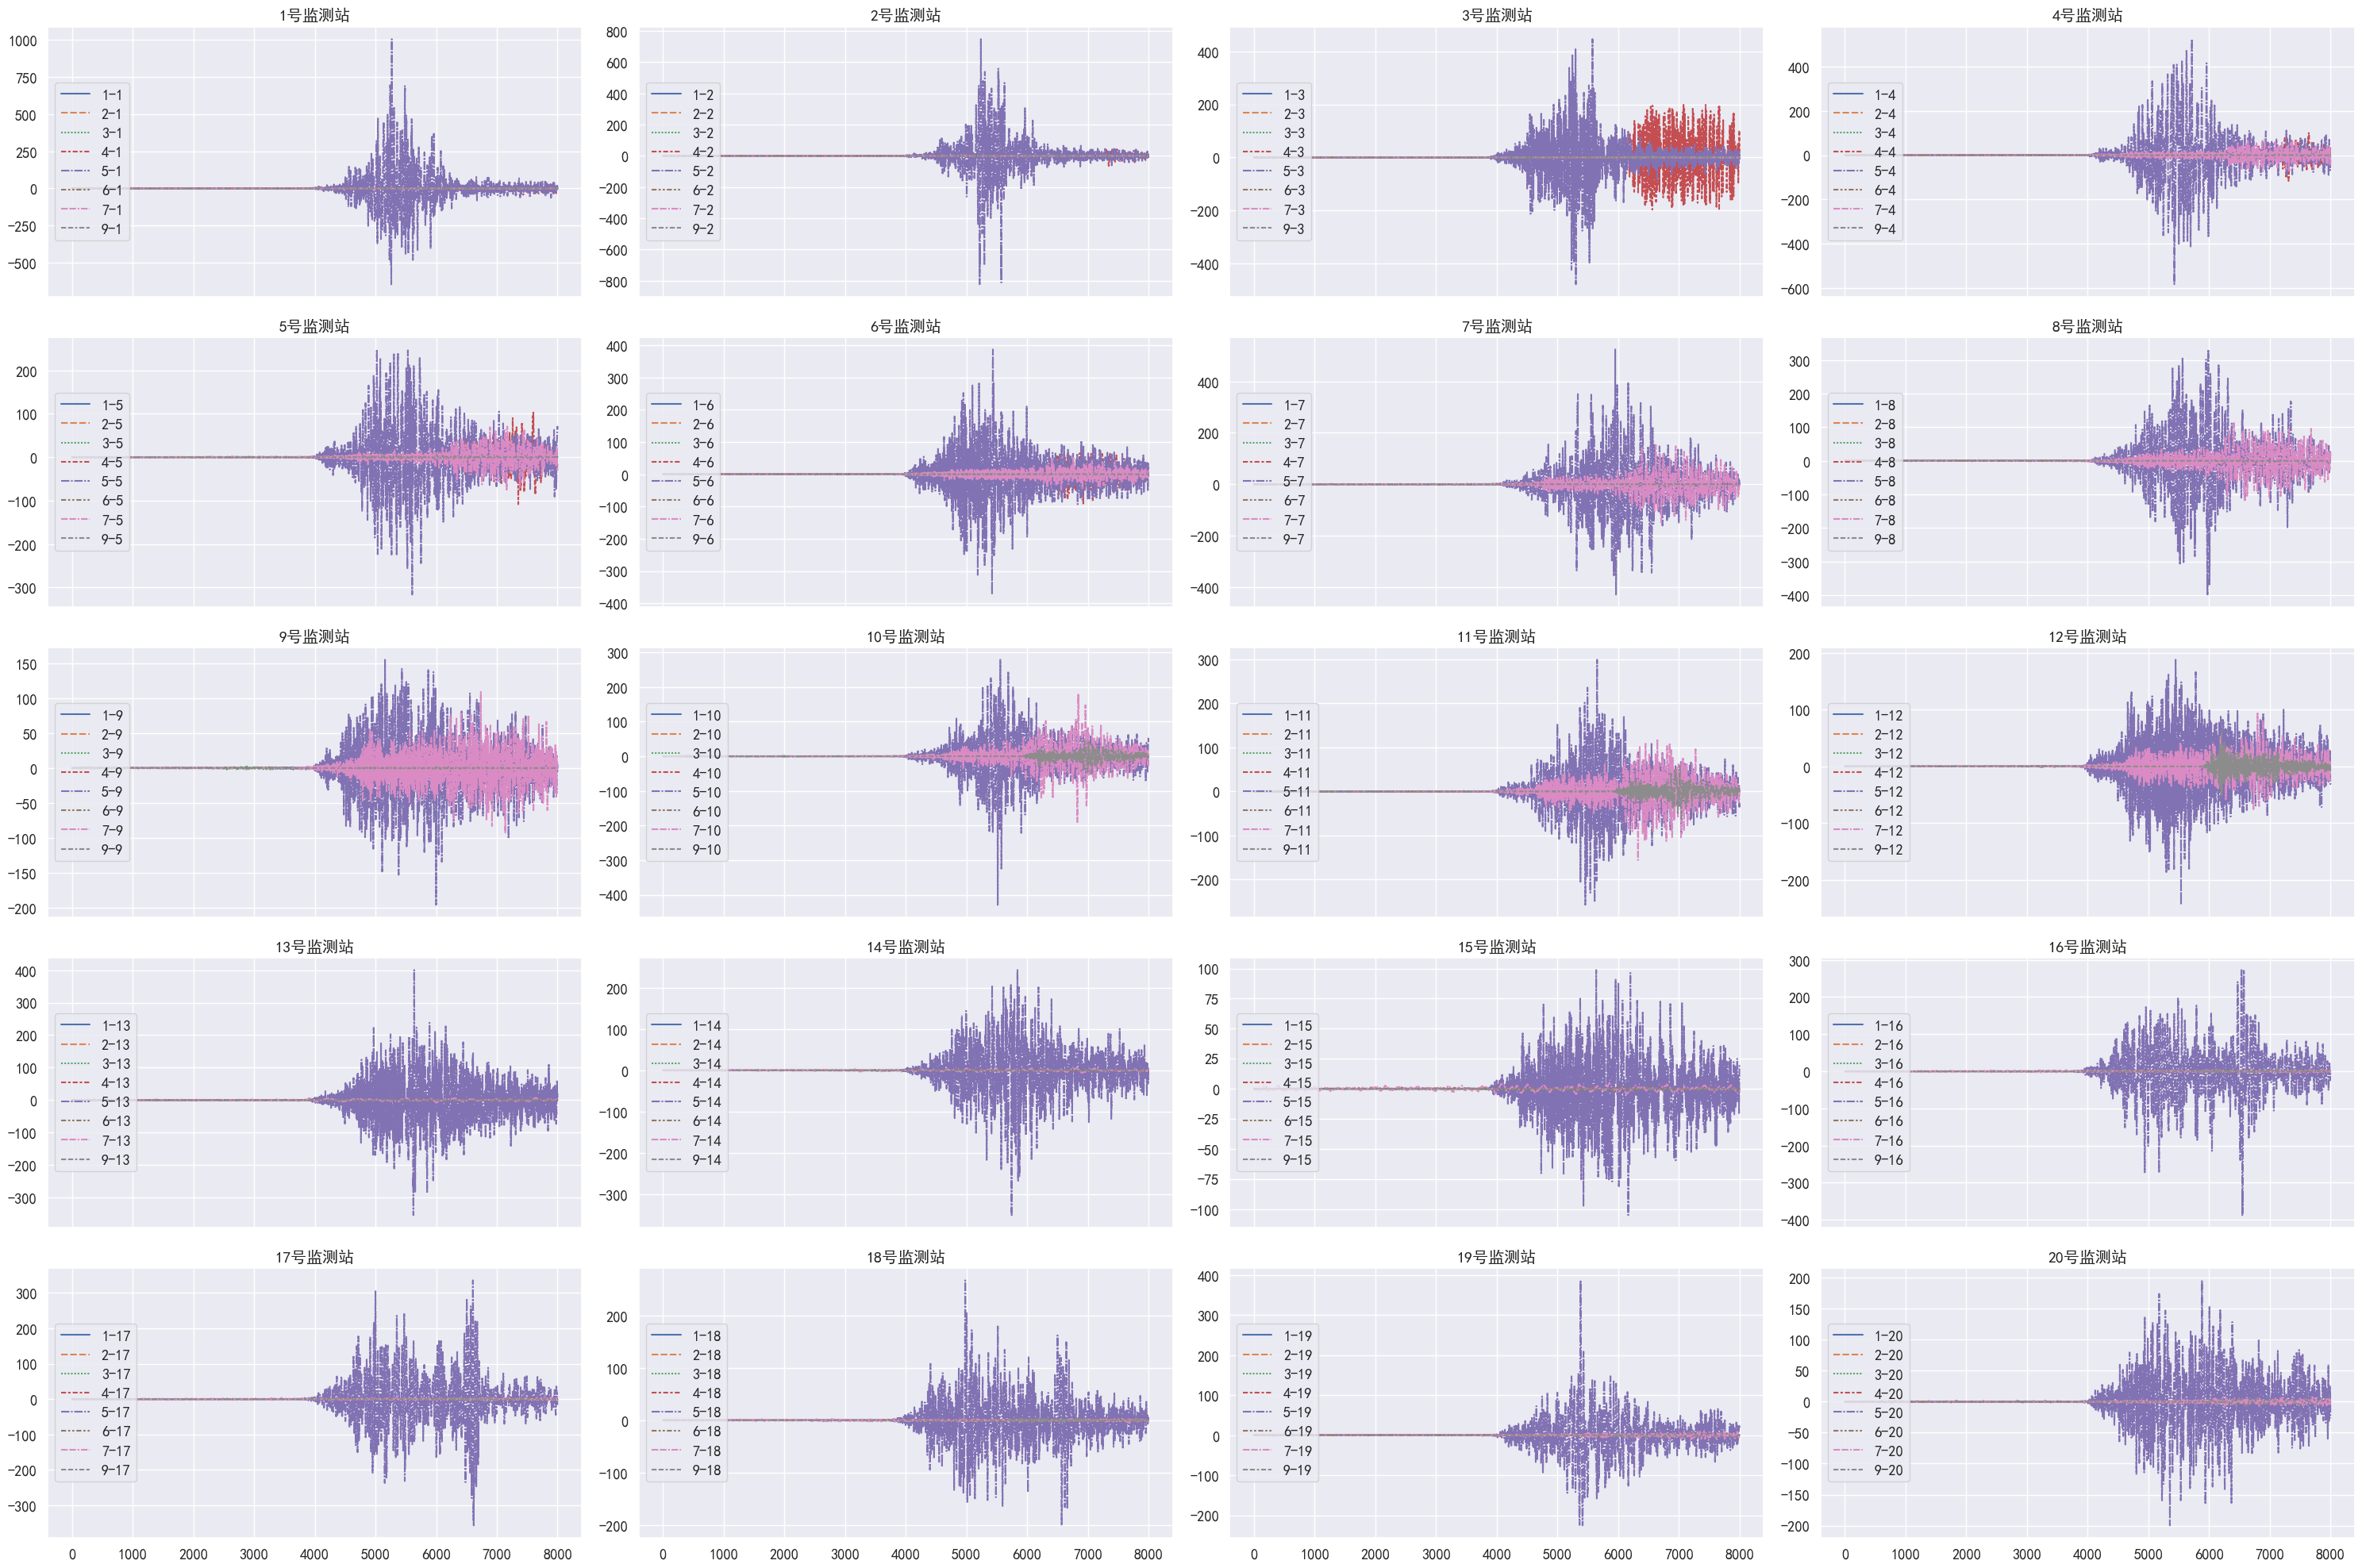

In [73]:
fig, axs = plt.subplots(5, 4, figsize=(30, 20), sharex='all')
cnt = 0
for i in tqdm.tqdm(range(5)):
    for ii in range(4):
        ax = axs[i, ii]
        sns.lineplot(df.iloc[:, cnt::20], ax=ax)
        ax.set_title(f'{cnt + 1}号监测站')
        ax.legend(loc='center left')
        cnt += 1

plt.tight_layout()
convertEMF.exportEmf('.', '监测站数据概览图')
plt.show()

剔除事件1

In [74]:
df = df.loc[:, [f'{i}-{ii}' for i in [3, 4, 6, 7, 9] for ii in range(1, 21)]]
df

,3-1,3-2,3-3,3-4,3-5,3-6,3-7,3-8,3-9,3-10,...,9-11,9-12,9-13,9-14,9-15,9-16,9-17,9-18,9-19,9-20
0,-0.008727,0.003094,0.003802,0.004047,0.004407,0.001995,0.013203,0.019760,0.003530,0.043104,...,0.093444,-0.039594,0.034525,-0.017206,0.037083,0.014242,-0.005727,0.001487,-0.004651,0.000754
1,-0.007791,0.003561,-0.004618,0.009193,0.005811,0.004801,-0.004105,-0.010646,0.002127,0.037959,...,-0.098345,-0.065790,0.022830,-0.015803,0.024453,0.000677,-0.000582,0.009907,-0.003247,-0.007198
2,0.005774,-0.002052,-0.000408,-0.005775,-0.015239,0.004801,-0.001766,-0.008307,-0.005825,0.027668,...,-0.083844,-0.049886,0.032186,-0.002705,0.038019,-0.008679,0.014387,-0.004594,-0.002780,-0.005327
3,-0.004985,-0.000181,0.001463,-0.000630,0.007682,0.003866,-0.004572,0.013678,-0.017052,0.027200,...,0.122446,0.003441,0.058382,0.015070,0.046439,0.006290,-0.005260,0.001954,-0.003247,0.011045
4,-0.000775,0.007304,-0.007425,0.001709,-0.017578,-0.012506,-0.008782,-0.016727,0.007272,0.022990,...,0.131334,-0.002640,0.060253,0.030507,0.049245,-0.009614,0.004564,0.000083,-0.017748,-0.010472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1.103647,-0.706524,0.528648,0.887211,-0.153701,0.577829,0.057642,0.376673,-2.007912,0.095963,...,7.072680,0.896428,0.855474,-0.456449,-0.032148,0.131654,-0.293878,0.063701,0.110423,-1.465260
7996,1.220124,-0.577885,0.498711,1.100985,-0.050790,0.479127,0.275626,0.530572,-1.922309,0.113271,...,5.946740,-2.363980,0.868572,-0.477967,-0.014840,0.351510,-0.117994,0.176903,0.114165,-1.481632
7997,1.139666,-0.470297,0.501517,1.236641,-0.011029,0.361715,0.457592,0.675115,-1.780104,0.138063,...,3.495588,-5.519137,0.892896,-0.539246,-0.015308,0.576511,0.027017,0.240989,0.117439,-1.503617
7998,0.930102,-0.401533,0.540343,1.254884,0.009085,0.241964,0.688674,0.797205,-1.622931,0.177356,...,0.451293,-7.890768,0.886815,-0.575732,-0.023728,0.787946,0.161269,0.239118,0.108551,-1.546653


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


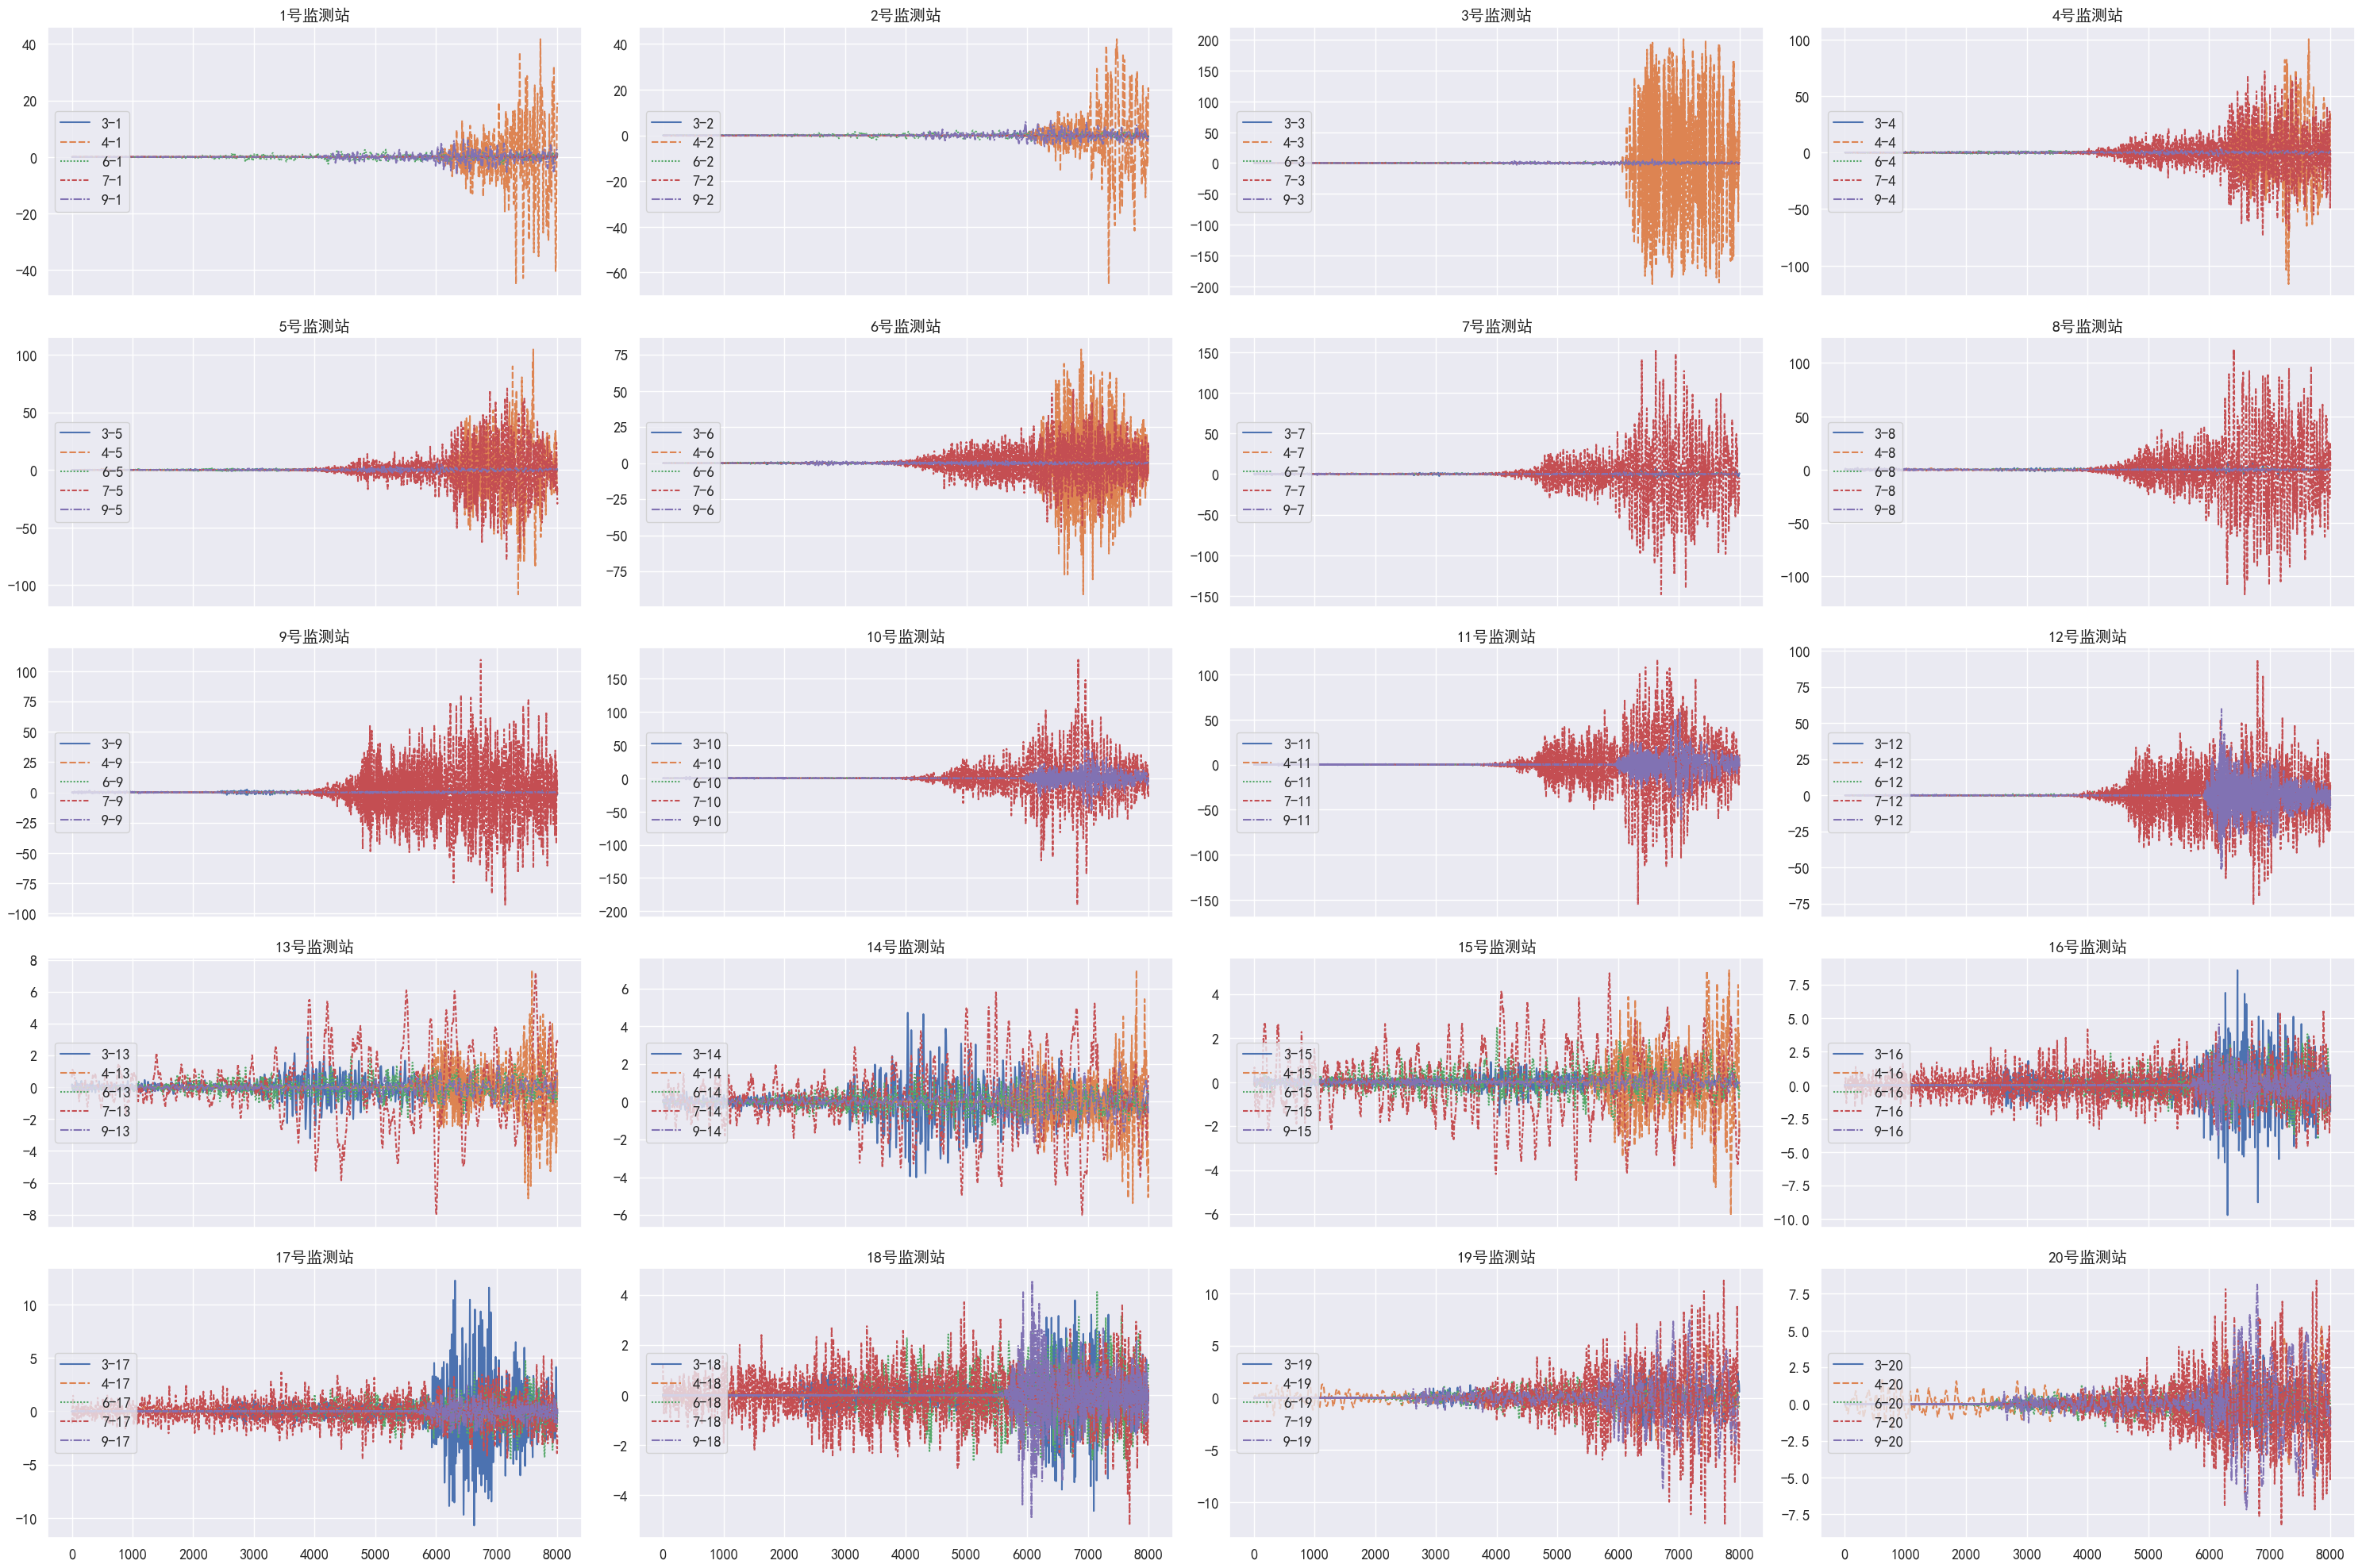

In [75]:
fig, axs = plt.subplots(5, 4, figsize=(30, 20), sharex='all')
cnt = 0
for i in tqdm.tqdm(range(5)):
    for ii in range(4):
        ax = axs[i, ii]
        sns.lineplot(df.iloc[:, cnt::20], ax=ax)
        ax.set_title(f'{cnt + 1}号监测站')
        ax.legend(loc='center left')
        cnt += 1

plt.tight_layout()
convertEMF.exportEmf('.', '剔除事件1-监测站数据概览图')
plt.show()

# 结果
去掉事件1和事件5，并且采用13号及以后的监测站
原因：
1. 事件1和5的震级小，但是振幅比其他事件都要大，不符合常理
2. 去除事件1和5之后，13号及以后的监测站的数据显示，各个事件振幅极差数量级恰当。而13号之前的监测站，各个时间振幅极差呈现出极大小值差异

# 特征工程
直接特征：
1. 振幅极差

小波变换后
2. 近似系数 近似系数能量
3. 细节系数 细节系数能量

In [76]:
df

,3-1,3-2,3-3,3-4,3-5,3-6,3-7,3-8,3-9,3-10,...,9-11,9-12,9-13,9-14,9-15,9-16,9-17,9-18,9-19,9-20
0,-0.008727,0.003094,0.003802,0.004047,0.004407,0.001995,0.013203,0.019760,0.003530,0.043104,...,0.093444,-0.039594,0.034525,-0.017206,0.037083,0.014242,-0.005727,0.001487,-0.004651,0.000754
1,-0.007791,0.003561,-0.004618,0.009193,0.005811,0.004801,-0.004105,-0.010646,0.002127,0.037959,...,-0.098345,-0.065790,0.022830,-0.015803,0.024453,0.000677,-0.000582,0.009907,-0.003247,-0.007198
2,0.005774,-0.002052,-0.000408,-0.005775,-0.015239,0.004801,-0.001766,-0.008307,-0.005825,0.027668,...,-0.083844,-0.049886,0.032186,-0.002705,0.038019,-0.008679,0.014387,-0.004594,-0.002780,-0.005327
3,-0.004985,-0.000181,0.001463,-0.000630,0.007682,0.003866,-0.004572,0.013678,-0.017052,0.027200,...,0.122446,0.003441,0.058382,0.015070,0.046439,0.006290,-0.005260,0.001954,-0.003247,0.011045
4,-0.000775,0.007304,-0.007425,0.001709,-0.017578,-0.012506,-0.008782,-0.016727,0.007272,0.022990,...,0.131334,-0.002640,0.060253,0.030507,0.049245,-0.009614,0.004564,0.000083,-0.017748,-0.010472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1.103647,-0.706524,0.528648,0.887211,-0.153701,0.577829,0.057642,0.376673,-2.007912,0.095963,...,7.072680,0.896428,0.855474,-0.456449,-0.032148,0.131654,-0.293878,0.063701,0.110423,-1.465260
7996,1.220124,-0.577885,0.498711,1.100985,-0.050790,0.479127,0.275626,0.530572,-1.922309,0.113271,...,5.946740,-2.363980,0.868572,-0.477967,-0.014840,0.351510,-0.117994,0.176903,0.114165,-1.481632
7997,1.139666,-0.470297,0.501517,1.236641,-0.011029,0.361715,0.457592,0.675115,-1.780104,0.138063,...,3.495588,-5.519137,0.892896,-0.539246,-0.015308,0.576511,0.027017,0.240989,0.117439,-1.503617
7998,0.930102,-0.401533,0.540343,1.254884,0.009085,0.241964,0.688674,0.797205,-1.622931,0.177356,...,0.451293,-7.890768,0.886815,-0.575732,-0.023728,0.787946,0.161269,0.239118,0.108551,-1.546653


In [94]:
特征工程筛选col = []
for i in df.columns:
    事件, 监测点 = list(map(int, i.split('-')))
    if 监测点 < 13 or 监测点 > 18:
        continue

    特征工程筛选col.append(i)

特征工程筛选col

['3-13',
 '3-14',
 '3-15',
 '3-16',
 '3-17',
 '3-18',
 '4-13',
 '4-14',
 '4-15',
 '4-16',
 '4-17',
 '4-18',
 '6-13',
 '6-14',
 '6-15',
 '6-16',
 '6-17',
 '6-18',
 '7-13',
 '7-14',
 '7-15',
 '7-16',
 '7-17',
 '7-18',
 '9-13',
 '9-14',
 '9-15',
 '9-16',
 '9-17',
 '9-18']

In [95]:
特征工程用df = df[特征工程筛选col]
特征工程用df

,3-13,3-14,3-15,3-16,3-17,3-18,4-13,4-14,4-15,4-16,...,7-15,7-16,7-17,7-18,9-13,9-14,9-15,9-16,9-17,9-18
0,0.082273,0.003054,-0.083656,0.012709,-0.019819,-0.005931,0.013310,-0.003979,-0.008908,-0.504021,...,0.474272,0.045762,-0.668258,1.265104,0.034525,-0.017206,0.037083,0.014242,-0.005727,0.001487
1,0.125777,0.004925,-0.075236,-0.019568,-0.001576,0.001085,0.013777,0.005845,-0.007037,-0.535362,...,0.458840,-0.077554,-0.833916,1.110840,0.022830,-0.015803,0.024453,0.000677,-0.000582,0.009907
2,0.154311,0.012877,-0.098157,0.057616,-0.035724,0.023071,0.013777,0.003974,-0.002359,-0.558751,...,0.466556,-0.154626,-0.972605,0.891012,0.032186,-0.002705,0.038019,-0.008679,0.014387,-0.004594
3,0.177232,0.047493,-0.080382,-0.001792,0.017135,0.007635,-0.002127,-0.024093,-0.013118,-0.590092,...,0.466556,-0.177748,-1.061213,0.651903,0.058382,0.015070,0.046439,0.006290,-0.005260,0.001954
4,0.192201,0.091464,-0.067752,-0.085524,-0.008592,-0.017158,-0.014290,0.009119,-0.003295,-0.608336,...,0.412548,-0.158480,-1.057360,0.432077,0.060253,0.030507,0.049245,-0.009614,0.004564,0.000083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.406554,0.361371,-0.208553,-1.042597,0.155130,-0.237481,1.045226,-5.063925,-1.937554,0.309911,...,-2.303295,0.038054,-3.661649,-0.705624,0.855474,-0.456449,-0.032148,0.131654,-0.293878,0.063701
7996,-0.408893,0.395987,-0.208553,-1.476695,0.082624,-0.194913,1.062534,-4.891315,-2.214946,0.308508,...,-2.172132,-0.112237,-3.442057,-0.451088,0.868572,-0.477967,-0.014840,0.351510,-0.117994,0.176903
7997,-0.416845,0.424521,-0.203407,-1.757828,-0.032917,-0.096680,0.796369,-4.370211,-2.395040,0.334236,...,-2.071831,-0.339600,-3.095332,-0.196552,0.892896,-0.539246,-0.015308,0.576511,0.027017,0.240989
7998,-0.418716,0.429667,-0.193116,-1.878982,-0.169508,0.031023,0.264974,-3.712984,-2.530695,0.379610,...,-2.006250,-0.624768,-2.713934,0.131260,0.886815,-0.575732,-0.023728,0.787946,0.161269,0.239118


In [96]:
def 小波特征(ndarray):
    signal = ndarray

    # 执行离散小波变换
    wavelet = 'db4'  # 选择小波函数（这里使用Daubechies-4小波）
    level = 3  # 变换的级数
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # 计算近似系数能量
    approx_coeffs = coeffs[0]
    approx_energy = np.sum(np.square(approx_coeffs))

    # 计算细节系数能量
    detail_coeffs = coeffs[1:]
    detail_energy = [np.sum(np.square(coeff)) for coeff in detail_coeffs]

    # 计算频率特征
    sample_rate = 200  # 采样率（如果你的信号是连续的，请设置合适的采样率）
    freqs = pywt.scale2frequency(wavelet, np.arange(level + 1) + 1e-6) * sample_rate

    # 输出结果
    # print("近似系数能量:", approx_energy)
    # print("细节系数能量:", detail_energy)
    # print("频率特征:", freqs)
    return approx_energy, detail_energy, freqs


def 构建特征(ndarray):
    极差 = ndarray.max() - ndarray.min()
    近似系数能量, detail_energy, freqs = 小波特征(ndarray)
    return 极差, 近似系数能量, detail_energy, freqs



In [115]:
特征df = pd.DataFrame()

样本list = []
极差list = []
近似系数能量list = []
震级list = []

事件与震级对照dict = {
    1: 4.2,
    2: 5.0,
    3: 6.0,
    4: 6.4,
    5: 7.0,
    6: 7.4,
    7: 8.0,

    9: 0,
}
detail_energyList = None
freqsList = None

for i in 特征工程用df.columns[:]:
    样本list.append(i)
    事件, 监测点 = list(map(int, i.split('-')))
    震级list.append(事件与震级对照dict[事件])

    极差, 近似系数能量, detail_energy, freqs = 构建特征(特征工程用df[i])
    极差list.append(极差)
    近似系数能量list.append(近似系数能量)

    detail_energy = np.asarray(detail_energy)
    if detail_energyList is None:
        detail_energyList = detail_energy
    else:
        detail_energyList = np.vstack((detail_energyList, detail_energy))

    freqs = np.asarray(freqs)
    if freqsList is None:
        freqsList = freqs
    else:
        freqsList = np.vstack((freqsList, freqs))

特征df['样本'] = 样本list
特征df['极差'] = 极差list
特征df['近似系数能量'] = 近似系数能量list
特征df = 特征df.join(pd.DataFrame(detail_energyList, columns=['细节系数能量0', '细节系数能量1', '细节系数能量2', ]))
# 特征df = 特征df.join(pd.DataFrame(freqsList, columns=['频率特征0', '频率特征1', '频率特征2', '频率特征3', ]))

特征df['震级'] = 震级list
特征df

,样本,极差,近似系数能量,细节系数能量0,细节系数能量1,细节系数能量2,震级
0,3-13,6.383756,2072.331899,52.694377,1.436153,0.136911,6.0
1,3-14,8.731063,5700.208532,109.756605,2.302670,0.138764,6.0
2,3-15,2.442265,329.288945,17.558916,0.875873,0.179045,6.0
3,3-16,18.303189,10364.026113,1215.409844,46.925355,6.943077,6.0
4,3-17,22.950090,23536.229581,1677.951217,59.091553,3.984665,6.0
5,3-18,8.422797,2106.166044,939.253539,49.004422,3.057180,6.0
6,4-13,14.348600,4883.639855,962.190304,75.622768,2.107963,6.4
7,4-14,12.346045,3143.953169,743.110597,71.521448,2.066941,6.4
8,4-15,11.135438,4090.847001,639.646670,114.774519,4.267030,6.4
9,4-16,2.980209,937.326782,1.624315,0.433726,0.255344,6.4


In [116]:
预测样本数 = 特征df['样本'].str.find('9-').value_counts()[0]
print('预测样本数', 预测样本数)

预测样本数 6


In [117]:
特征df.iloc[:, 1:-1] = pd.DataFrame(preprocessing.minmax_scale(特征df.iloc[:, 1:-1]),
                                    columns=特征df.iloc[:, 1:-1].columns)
特征df

,样本,极差,近似系数能量,细节系数能量0,细节系数能量1,细节系数能量2,震级
0,3-13,0.231995,0.056599,0.031286,0.011377,0.000357,6.0
1,3-14,0.340815,0.166209,0.065297,0.018936,0.000629,6.0
2,3-15,0.049270,0.003936,0.010344,0.006490,0.006545,6.0
3,3-16,0.784573,0.307119,0.724308,0.408168,1.000000,6.0
4,3-17,1.000000,0.705094,1.000000,0.514291,0.565489,6.0
5,3-18,0.326524,0.057622,0.559708,0.426304,0.429266,6.0
6,4-13,0.601240,0.141538,0.573380,0.658489,0.289851,6.4
7,4-14,0.508403,0.088976,0.442800,0.622714,0.283826,6.4
8,4-15,0.452280,0.117585,0.381132,1.000000,0.606960,6.4
9,4-16,0.074209,0.022307,0.000846,0.002633,0.017751,6.4


In [118]:
预测特征df = 特征df[-预测样本数:]
train特征df = 特征df[:-预测样本数]

In [119]:
train特征df.to_excel('train特征df.xlsx', index=False)

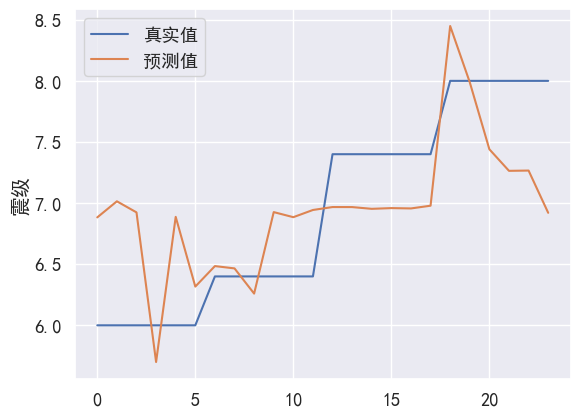

0.44333356666979196


In [129]:
model = linear_model.LinearRegression()
X = train特征df.iloc[:, 1:-1]
y = train特征df.iloc[:, -1]
model.fit(X, y)
y_pred = model.predict(X)

sns.lineplot(x=np.arange(len(y)), y=y, label='真实值')
sns.lineplot(x=np.arange(len(y)), y=y_pred, label='预测值')
plt.show()

print(r2_score(y, y_pred))

In [132]:
预测结果 = model.predict(预测特征df.iloc[:, 1:-1])
预测结果

array([6.92360186, 6.9332139 , 6.95226646, 6.80629573, 6.88458334,
       6.7763565 ])

In [133]:
预测结果.mean()

6.879386298589574